### Regression Model

Doing a regression odel to predict things that aren't easy. 
https://www.tensorflow.org/tutorials/keras/regression

In [4]:
# Make sure you have this. I haven't made extensive use of this before, so this could be fun
!pip install -q seaborn

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('dark_background')


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [7]:
# Get the data and load it in
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [8]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [9]:
# Find number of null values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [10]:
# Removes the rows with null values
dataset = dataset.dropna()

In [11]:
# The origin column should actually be categries - will convert them to one-hot encodings
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [12]:
# Convert catagorical data into one-hot encoded data
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [13]:
len(dataset)

392

In [14]:
# Now break it up into training and test data
train_dataset = dataset.sample(frac=0.8, random_state=0)
 # Drop all data not included in the other dataset based on index
test_dataset = dataset.drop(train_dataset.index)

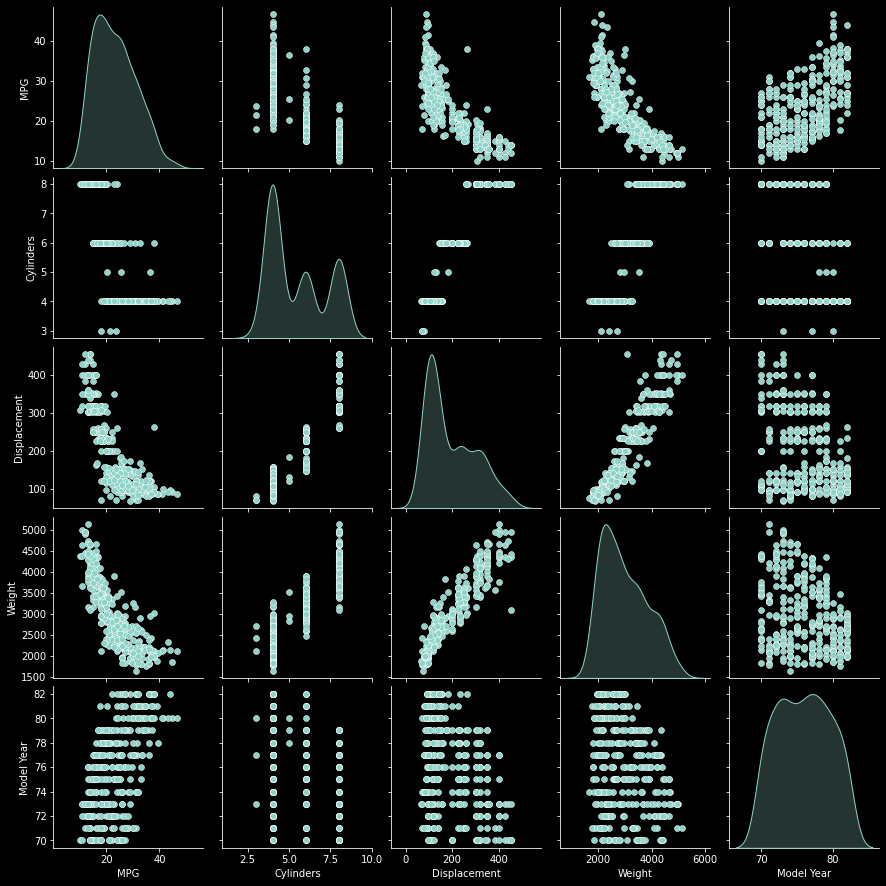

In [15]:
"""
Now let's take a look at the data. The main thing that is showing is that MPG is a function of the
other variables. This is kind of what we expectd.
"""
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight', 'Model Year']], diag_kind='kde')

In [16]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [17]:
# Or, more better:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [18]:
# Pull the label from the features.
# Label / Target / output
# Features / Inputs
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [19]:
"""
Now we have a problem that the values vary by quiet a bit. This is a problem because the model
weights are multiplied by the input values. Wildy varying input can negatively effect the output.
Blah blah, got to normalize it.
"""
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [20]:
# preprocessing.Normalization takes care of this and can be a layer in the model. Isn't that nice.
normalizer = preprocessing.Normalization()

In [21]:
normalizer.adapt(np.array(train_features))

In [22]:
# print("Raw Mean: ",print(normalizer.mean.numpy()))
# print("Raw Variance: ",print(normalizer.variance.numpy()))
first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


### Basic Linear Regression Modeling

First off we'll try linear regression - that is, relating on variable to another via a straight line. In this case, we'll be relating MPG to Horsepower. As we'll see, this isn't a perfect relationship, as there are other factor that affect MPG. Not to mention it isn't linear to begin with. Let's go!

In [23]:
# Normalize the horsepowers variable
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

In [24]:
# Build the model
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [25]:
# Let's run the untrained model - never done the before
horsepower_model.predict(horsepower[:10])


array([[-1.178],
       [-0.665],
       [ 2.175],
       [-1.652],
       [-1.494],
       [-0.587],
       [-1.77 ],
       [-1.494],
       [-0.389],
       [-0.665]], dtype=float32)

In [26]:
# The loss method is important here as it defines how we "train" the model. In this case we are basically
# just telling is to r^2. 
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [27]:
%%time
# Train it
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 10.2 s


In [28]:
# Check the training progress
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802845,4.183682,95
96,3.803575,4.192742,96
97,3.803085,4.188107,97
98,3.803740,4.178435,98
99,3.807578,4.193689,99


In [29]:
def plot_loss(history):
    """
    Take the model's "fit" output and graphs it
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.title("Training Loss")
    plt.grid(True)

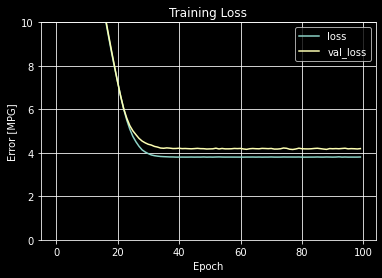

In [30]:
plot_loss(history)

In [31]:
# Save test results for later comparison
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [32]:
# Create a sample to plot out the model predictions
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [33]:
def plot_horsepower(x, y):
    """
    Basically just plotting the x and y since the model input is already calculated
    """
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='r', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.title('Predictions')
    plt.legend()

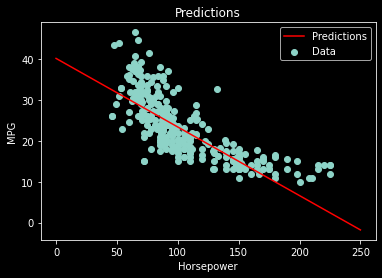

In [34]:
plot_horsepower(x,y)

### Multiple Inputs to Linear Regression
Can do almost the same exact thing to add multiple inputs to the linear regression model

In [35]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [36]:
linear_model.predict(train_features[:10])

array([[ 1.182],
       [ 0.195],
       [-2.312],
       [ 1.459],
       [ 1.413],
       [-0.238],
       [ 1.621],
       [ 0.724],
       [-0.102],
       [ 0.778]], dtype=float32)

In [37]:
# Observe 'shape' is (9,1) since we now have 9 inputs instead of the one
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.304],
       [-0.64 ],
       [-0.598],
       [-0.467],
       [-0.172],
       [ 0.088],
       [ 0.31 ],
       [ 0.14 ],
       [ 0.059]], dtype=float32)>

In [38]:
# Same as above
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [39]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 9.29 s


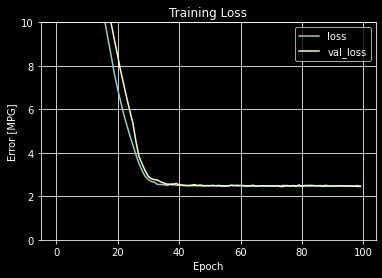

In [40]:
# Lower training loss. Better?
plot_loss(history)

In [41]:
# Get results
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

Last time we created mock horsepower data to see how it related - since this is a 9 dimensional problem we can't really do that. Rather, I don't feel like created 9 dimensions of variables and figuring out how to plot that. So just trust that it works and moving on!

### DNN Regression Model
This is what we are all here for. Interestingly, we will use almost the same methods as above, except when building the model we wille expand to include hidden and non-linear layers.

In [51]:
# build and compile modle - relu is a non-linear activation so should give better results
def build_and_compile_model(norm):
    """
    Compile a model using the inputs as a starting point. In this way, we can use one or 100 inputs 
    and it will create the model for the given inputs
    """
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [44]:
# get the model and go
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [45]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 9.99 s


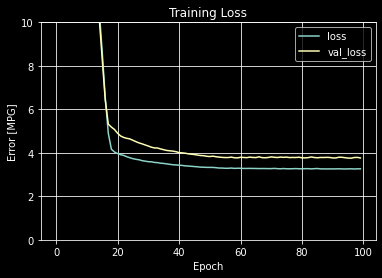

In [46]:
plot_loss(history)


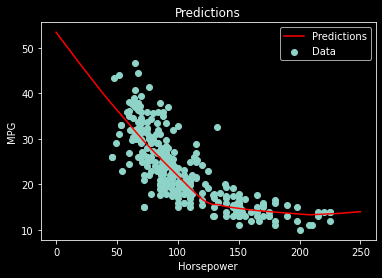

In [48]:
# Same thing as before, but now with a non-linear model. Does much better
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x, y)

In [49]:
# Collect results
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [55]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_8 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [56]:
%%time
# Train it
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 9.72 s


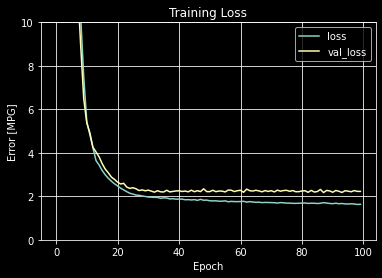

In [57]:
plot_loss(history)

In [59]:
# Evaluate 
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

### Evaluating the various runs

In [62]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.645957
linear_model,2.460109
dnn_horsepower_model,2.937599
dnn_model,1.606101


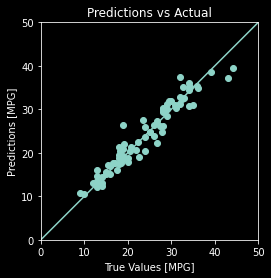

In [66]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.title('Predictions vs Actual')
_ = plt.plot(lims, lims)

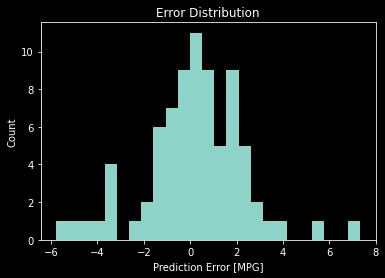

In [65]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.title('Error Distribution')
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [67]:
# Save for later
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [68]:
# Load the model again
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [70]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.645957
linear_model,2.460109
dnn_horsepower_model,2.937599
dnn_model,1.606101
reloaded,1.606101


In [71]:
# All done!